In [ ]:
# !wget https://www.cs.ccu.edu.tw/~wtchu/projects/Weather/Image.zip
# !unzip Image.zip
# !mv Image weather_dataset

# Split Dataset to Train, Val, Test

In [1]:
!pip install split-folders

In [2]:
import split_folders

In [3]:
split_folders.ratio("Image", output="weather_dataset", seed=1337, ratio=(0.7,0.15,0.15))

Copying files: 8408 files [00:07, 1122.94 files/s]


In [4]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split as rsplit
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os
import torchvision.models


In [5]:
def get_data_loader(batch_size=8, sets=["train", "val", "test"], tlearning=False):
    torch.manual_seed(1000)    
    data_loader = []
    
    data_transform = transforms.Compose( [transforms.CenterCrop(224), transforms.Resize((224,224)) , transforms.ToTensor()])
    
    # Load dataset based on the passed in folder name & whether it is transfer learning or not.
    for s in sets:
        if tlearning:
            data_set  = torchvision.datasets.DatasetFolder("weather_dataset/{}".format("anet_{}".format(s)), 
                                                          loader=torch.load, extensions=('.tensor'))
        else:
            data_set = ImageFolder("weather_dataset/{}".format(s),
                               transform=data_transform)
        
        print("Complete Dataset:\n ", data_set)
        data_loader.append(torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=True))
    
    return data_loader

In [6]:
def get_model_path(name, bs, lr, data_set, total_epoch, epoch, csv=False, tlearning=False):
    if csv:
        model_path = "{}_BS_{}_LR_{}_dataset_{}_numepochs_{}/".format(name, bs, lr, data_set, total_epoch)
        if tlearning:
            model_path = "{}_BS_{}_LR_{}_dataset_{}_numepochs_{}/".format(name,bs, lr, "anet_{}".format(data_set),total_epoch)
    else:
        model_path = "{}_BS_{}_LR_{}_dataset_{}_numepochs_{}/epoch_{}".format(name, bs, lr, data_set, total_epoch,epoch)
        if tlearning:
            model_path = "{}_BS_{}_LR_{}_dataset_{}_numepochs_{}/epoch_{}".format(name,bs, lr, "anet_{}".format(data_set),epoch)
    
    return model_path

In [7]:
def get_accuracy(model, data_loader, conf_matrix=False):
    # calculate total correct predictions within the specified data_set

#     classes = ['cloudy', 'foggy', 'rain', 'snow', 'sunny', 'z-other']
    classes = ['cloudy', 'foggy', 'rain', 'snow', 'sunny']
    
    x = np.zeros(shape=(len(classes), len(classes)))
#     print(x.shape)

    l = 0
    correct, total = 0 , 0
    for images, labels in data_loader:
        images = images.cuda()
        labels = labels.cuda()
        
        outputs = model(images)
        
        pred = outputs.max(1, keepdim=True)[1]
        
        if conf_matrix:
            i = labels.view_as(pred).item()
            j = pred.item()
            x[i][j] += 1
            
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += images.shape[0]
        
        l+=1
    if conf_matrix:
        return (correct / total), x
    else:
        return (correct / total)

In [8]:
def train_net(net, batch_size=8, lr=0.01, num_epochs=20, data_set=["train", "val"], weight_decay=0, tlearning=False):
    model_path = "{}_BS_{}_LR_{}_dataset_{}_numepochs_{}/".format(net.name,batch_size, lr, data_set[0],num_epochs)
    
    if tlearning:
        model_path = "{}_BS_{}_LR_{}_dataset_{}_numepochs_{}/".format(net.name,batch_size, lr, "anet_{}".format(data_set[0]),num_epochs)
    
    
    os.mkdir(model_path)
    
    
    with open('./{}network_params.txt'.format(model_path),'w') as file:    
        print(net.parameters, file=file)
    
    torch.manual_seed(1000)
    
    data_loader = get_data_loader(batch_size=batch_size, sets=data_set, tlearning=tlearning)
    train_loader, val_loader = data_loader
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    
    train_acc, train_loss = [], []
    val_acc, val_loss = [], []
    iters = []
    
    for epoch in range(num_epochs):
        print("Epoch: ", epoch)
        
        batch_total =0.0
        
        # go through data loaded in batches of batch_size
        # i.e. # of data loaded / batch_size should be number of iterations
        
#         num_images=0
        j = 0
        total_loss = 0
        for i, data in enumerate(train_loader, 0):
#             if i > 10000:
#                 break
                
            images, labels = data

#             print(labels)
    
            images = images.cuda()
            labels = labels.cuda()

            
            outputs = net(images)
#             print(outputs.shape)
            loss = criterion(outputs, labels.long())
            loss.backward()
            total_loss+=float(loss)
            j+=images.shape[0]
            optimizer.step()
            optimizer.zero_grad()

            pred = outputs.max(1, keepdim=True)[1]
            
#             print(pred)
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
#             print(pred)
            mini_batch_total = images.shape[0]
#             train_acc.append(mini_batch_correct / mini_batch_total)

            print("Epoch {}, Mini Batch Accuracy {:.2f}%, Loss {:.2f}%".format(epoch ,mini_batch_correct/mini_batch_total * 100 , total_loss/j * 100))
            
#             n+=1
        
        iters.append(epoch)
        train_acc.append(get_accuracy(net, train_loader))
        val_acc.append(get_accuracy(net, val_loader))
        train_loss.append(total_loss/j)
        
        print("\nEpoch {} Summary: Train Accuracy {:.2f}%, Validation Accuracy {:.2f}%, Loss {:.2f}%\n".format(epoch,
                                                                                                          train_acc[-1] * 100,
                                                                                                          val_acc[-1] * 100,
                                                                                                          total_loss/j * 100))
        
        torch.save(net.state_dict(), model_path + "epoch_{}".format(str(epoch)))           



    
    np.savetxt("{}train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}iters.csv".format(model_path), iters)
    
    return iters, train_loss, val_acc, train_acc


# Network Definitions

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name="CNN"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 53 * 53, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class anet_CNN(nn.Module):
    def __init__(self):
        super(anet_CNN, self).__init__()
        self.name="anetCNN"
        self.conv1 = nn.Conv2d(256, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5*2*2, 64)
        self.fc2 = nn.Linear(64, 5)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = x.view(-1, 5*2*2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
def plot_graphs(iters, train_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [11]:
def print_conf_matrix(conf_matrix):
    print("\n\n")

    classes = ['cloudy', 'foggy', 'rain', 'snow', 'sunny']

    for i in range(len(classes)):
        if i == 0:
            print('', end='\t')

        print(classes[i], end = '\t')

    print('\n')

    for i in range(len(classes)):

        print(classes[i], end ='\t')
        for j in range(len(classes)):
            print(conf_matrix[i][j], end='\t')
        print('\n')

In [12]:
def save_anet_feats(sets = ["train", "val", "test"]):
    root_path = "weather_dataset/"
    classes = ['cloudy', 'foggy', 'rain', 'snow', 'sunny']
    alexnet = torchvision.models.alexnet(pretrained=True)
    
    data_loader = get_data_loader(batch_size=1, sets=sets)
    
    for i, data in enumerate(data_loader):
        path = "{}/anet_{}".format(root_path, sets[i])
        
        if not os.path.isdir(path):
            os.mkdir(path)
            
        n = 0
        
        for images, labels in data:
            features = alexnet.features(images)
            features_tensor = torch.from_numpy(features.detach().numpy())
            folder = "{}/{}/".format(path, classes[labels])
            
            if not os.path.isdir(folder):
                os.mkdir(folder)
                
            torch.save(features_tensor.squeeze(0), '{}/{}.tensor'.format(folder, str(n)))
            n+=1
    
    

# Running Regular CNN

In [ ]:
net = CNN().cuda()
iters, train_loss, val_acc, train_acc = train_net(net, num_epochs=30, lr=0.01, batch_size=512, data_set=["train","val"])


In [ ]:
plot_graphs(iters, train_loss, train_acc, val_acc)
print(train_acc[-1])

In [ ]:
data_loader = get_data_loader(batch_size=1, sets=["val"])
x, y = get_accuracy(net, data_loader[0], conf_matrix=True)

In [ ]:
print(x)
print_conf_matrix(y)

# Running AlexNet 

In [13]:
save_anet_feats(sets = ["train", "val", "test"]) #if using alexnet transfer learning

Complete Dataset:
  Dataset ImageFolder
    Number of datapoints: 23532
    Root location: weather_dataset/train
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Complete Dataset:
  Dataset ImageFolder
    Number of datapoints: 1258
    Root location: weather_dataset/val
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Complete Dataset:
  Dataset ImageFolder
    Number of datapoints: 1267
    Root location: weather_dataset/test
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [14]:
net = anet_CNN().cuda()
iters, train_loss, val_acc, train_acc = train_net(net, num_epochs=50, lr=0.01, batch_size=512, data_set=["train","val"], tlearning=True)

Complete Dataset:
  Dataset DatasetFolder
    Number of datapoints: 23532
    Root location: weather_dataset/anet_train
Complete Dataset:
  Dataset DatasetFolder
    Number of datapoints: 1258
    Root location: weather_dataset/anet_val
Epoch:  0
Epoch 0, Mini Batch Accuracy 22.07%, Loss 0.32%
Epoch 0, Mini Batch Accuracy 18.75%, Loss 0.32%
Epoch 0, Mini Batch Accuracy 23.24%, Loss 0.32%
Epoch 0, Mini Batch Accuracy 19.73%, Loss 0.32%
Epoch 0, Mini Batch Accuracy 22.46%, Loss 0.32%
Epoch 0, Mini Batch Accuracy 22.66%, Loss 0.32%
Epoch 0, Mini Batch Accuracy 21.88%, Loss 0.32%
Epoch 0, Mini Batch Accuracy 23.24%, Loss 0.32%
Epoch 0, Mini Batch Accuracy 24.41%, Loss 0.31%
Epoch 0, Mini Batch Accuracy 22.46%, Loss 0.31%
Epoch 0, Mini Batch Accuracy 21.29%, Loss 0.31%
Epoch 0, Mini Batch Accuracy 22.85%, Loss 0.31%
Epoch 0, Mini Batch Accuracy 21.48%, Loss 0.31%
Epoch 0, Mini Batch Accuracy 21.88%, Loss 0.31%
Epoch 0, Mini Batch Accuracy 19.73%, Loss 0.31%
Epoch 0, Mini Batch Accuracy 25.0

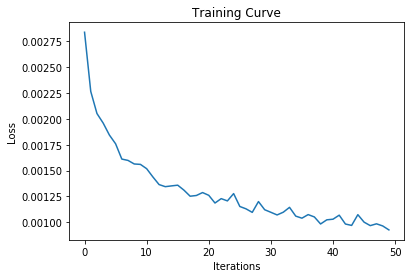

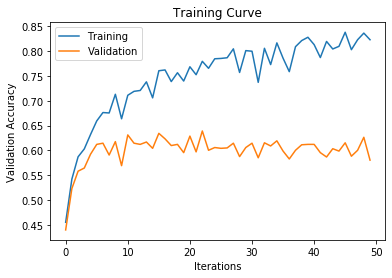

Final Training Accuracy: 0.8230919598844127
Final Validation Accuracy: 0.5802861685214626
0.8230919598844127


In [15]:
plot_graphs(iters, train_loss, train_acc, val_acc)
print(train_acc[-1])

In [16]:
data_loader = get_data_loader(batch_size=1, sets=["val"], tlearning=True)
x, y = get_accuracy(net, data_loader[0], conf_matrix=True)

Complete Dataset:
  Dataset DatasetFolder
    Number of datapoints: 1258
    Root location: weather_dataset/anet_val


In [17]:
print(x)
print_conf_matrix(y)

0.5802861685214626



	cloudy	foggy	rain	snow	sunny	

cloudy	140.0	36.0	43.0	19.0	35.0	

foggy	11.0	188.0	5.0	13.0	2.0	

rain	51.0	36.0	115.0	32.0	19.0	

snow	25.0	38.0	30.0	146.0	19.0	

sunny	76.0	7.0	20.0	11.0	141.0	



In [ ]:
# model_path = get_model_path(model.name, bs=256, lr=0.001, data_set="train", total_epoch=100, epoch=100,csv=True)
# state = torch.load(model_path + "epoch_100")
# model.load_state_dict(state)

# iters = np.loadtxt(open(model_path +"iters.csv", "rb"), delimiter=",")
# train_acc = np.loadtxt(open(model_path + "train_acc.csv", "rb"), delimiter=",")
# train_loss = np.loadtxt(open(model_path+ "train_loss.csv", "rb"), delimiter=",")
# val_acc = np.loadtxt(open(model_path + "val_acc.csv", "rb"), delimiter=",")

# plot_graphs(iters, train_loss, train_acc, val_acc)